In [1]:
from getpass import getpass
import urllib

user = input('User name: ')
password = getpass('Password: ')
password = urllib.parse.quote(password) # your password is converted into url format
AUTHENTICATION = '{}:{}'.format(user, password)

!git clone https://$AUTHENTICATION@github.com/ZisisFl/nlp-media-source-analysis.git
AUTHENTICATION = '' # remove authentication variable

User name: ZisisFl
Password: ··········
Cloning into 'nlp-media-source-analysis'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 181 (delta 14), reused 21 (delta 2), pack-reused 148
Receiving objects: 100% (181/181), 248.22 MiB | 35.09 MiB/s, done.
Resolving deltas: 100% (93/93), done.
Checking out files: 100% (60/60), done.


In [2]:
%cd nlp-media-source-analysis

/content/nlp-media-source-analysis


### Libraries

In [3]:
import tensorflow as tf
import re
import gensim
import numpy as np
import matplotlib.pyplot as plt
from os import path
from models_helper_functions import evaluate_model, prepare_target_articles, encode_articles
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D

### Check GPU availabillity

In [4]:
# check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### Load articles and their labels

In [24]:
# choose classification type in order to prepare data accordingly
classification_type='political_bias'# political_bias/media_source

# load dataframe of articles and labels
articles_df, labels_dict = prepare_target_articles(classification_type=classification_type,
                                                   keep_english=False,
                                                   balance_classes=False)

# number of labels to predict
n_labels_to_predict = len(labels_dict.keys())

### Tokenize articles and create padded sequences of them

In [25]:
articles = articles_df['processed_main_text'].values

# create labels based on classification type selected
if classification_type == 'political_bias':
    labels = articles_df['political_bias_label'].values
else:
    labels = articles_df['source_label'].values

# init tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(articles)

# create sequneces out of articles
sequences = tokenizer.texts_to_sequences(articles)

# get maximum article length in order to pad sequences to that length
max_length = max([len(s.split()) for s in articles])

# define vocab size
word_index = tokenizer.word_index
vocabulary_size = len(word_index)
print('Found %s unique tokens.' % vocabulary_size)

# pad sequences
data = pad_sequences(sequences, maxlen=max_length, padding='post')

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 102769 unique tokens.
Shape of data tensor: (12882, 8338)
Shape of label tensor: (12882,)


### Split articles into training set and validation set

In [26]:
indices = np.arange(data.shape[0])
# shuffle indices
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# number of validation samples
validation_samples = int(0.25 * data.shape[0])

x_train = data[:-validation_samples]
y_train = labels[:-validation_samples]
x_val = data[-validation_samples:]
y_val = labels[-validation_samples:]

print("Train Shapes - X: {} - Y: {}".format(x_train.shape, y_train.shape))
print("Val Shapes - X: {} - Y: {}".format(x_val.shape, y_val.shape))

Train Shapes - X: (9662, 8338) - Y: (9662,)
Val Shapes - X: (3220, 8338) - Y: (3220,)


In [27]:
embdding_dimension = 100

### Define training history ploting function

In [9]:
def plot_training_history(history):
    # summarize history for accuracy
    plt.figure(figsize=(16,8))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.figure(figsize=(16,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Models without embedding layer initialization
Train embedding layer to learn new representations of words

#### Bidirectional LSTM Model

In [ ]:
# set up early stopping callback
callback = EarlyStopping(monitor='loss', patience=2)

with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Embedding(input_dim=vocabulary_size+1,
                        output_dim=embdding_dimension,
                        input_length=max_length))
    model.add(Bidirectional(LSTM(100)))
    model.add(Dropout(0.6))
    model.add(Dense(n_labels_to_predict, activation='sigmoid'))

    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    history = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_val, y_val), verbose=1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 8338, 100)         10277000  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               160800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 402       
Total params: 10,438,202
Trainable params: 10,438,202
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
302/302 [==============================] - 220s 720ms/step - loss: 0.6604 - accuracy: 0.6189 - val_loss: 0.5669 - val_accuracy: 0.7143
Epoch 2/5
302/302 [==============================] - 217s 720ms/step - loss: 0.4588 - accuracy:

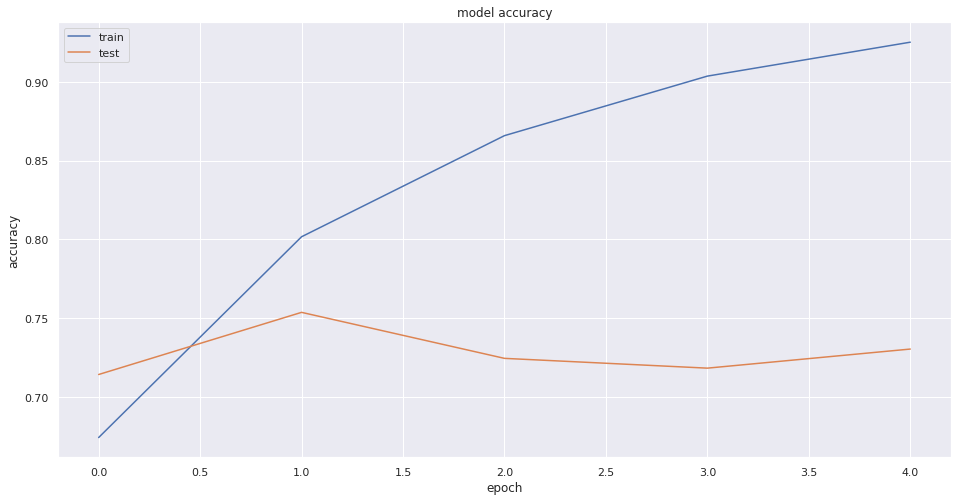

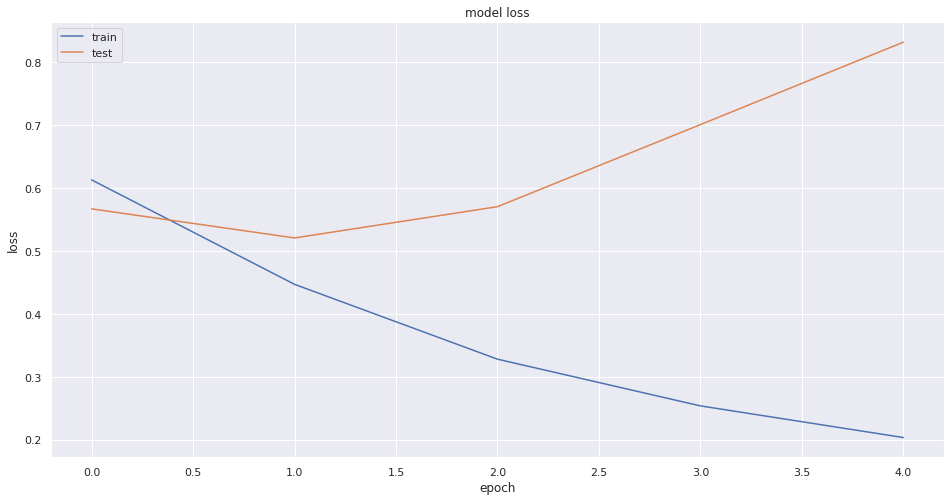

In [ ]:
# plot training lines
plot_training_history(history)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy score: 0.730
Recall score: 0.727
Precision score: 0.729
F1 score: 0.728
Classification report:
              precision    recall  f1-score   support

        left       0.74      0.77      0.75      1733
       right       0.72      0.68      0.70      1487

    accuracy                           0.73      3220
   macro avg       0.73      0.73      0.73      3220
weighted avg       0.73      0.73      0.73      3220



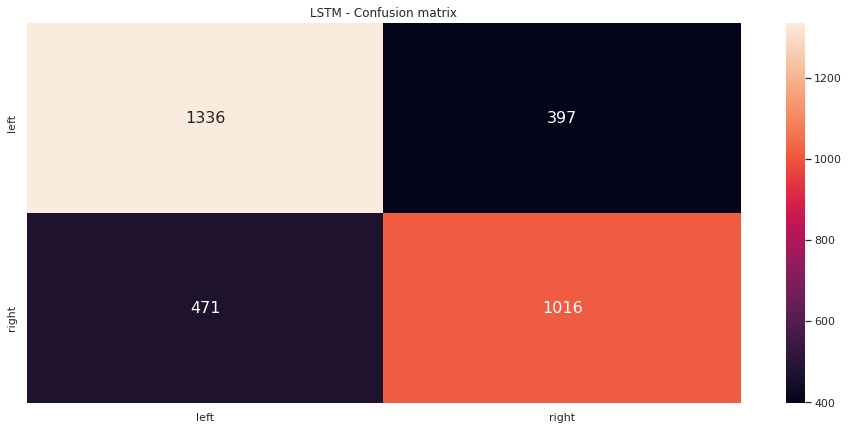

In [ ]:
# make prediction
y_pred = model.predict_classes(x_val)
evaluate_model('lstm', y_val, y_pred, labels_dict)

#### Convolutional NN

In [14]:
# set up early stopping callback
callback = EarlyStopping(monitor='loss', patience=2)

with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Embedding(input_dim=vocabulary_size + 1,
                        output_dim=embdding_dimension,
                        input_length=max_length))
    
    model.add(Conv1D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(250, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(n_labels_to_predict, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    history = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_val, y_val), verbose=1, callbacks=[callback])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8338, 100)         10277000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8338, 32)          9632      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4169, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 133408)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               33352250  
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

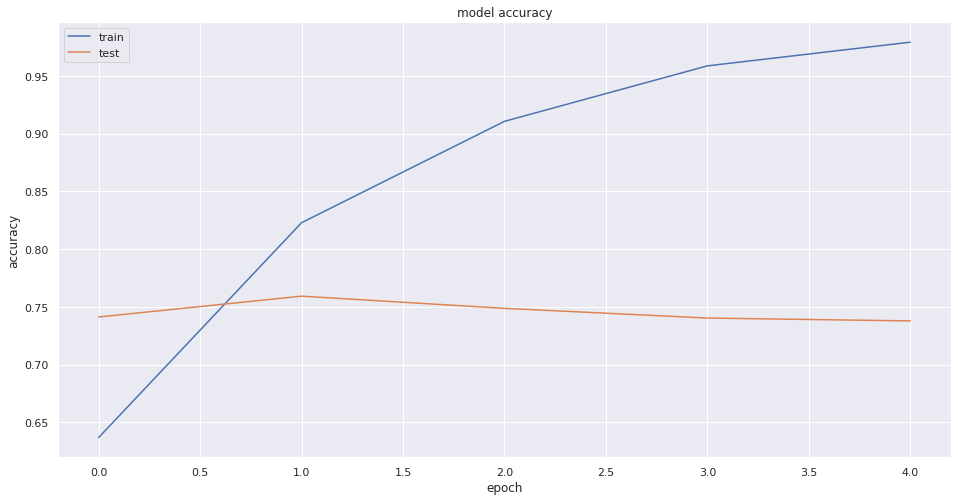

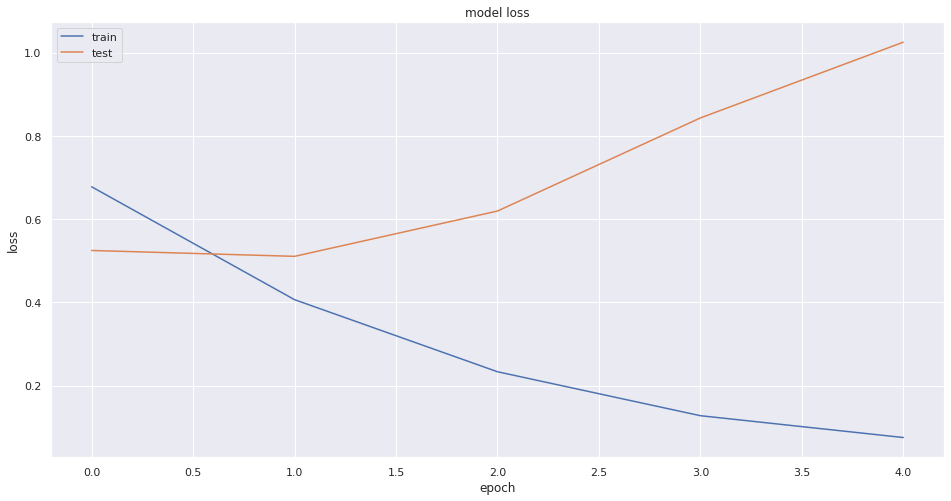

In [15]:
# plot training lines
plot_training_history(history)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy score: 0.738
Recall score: 0.735
Precision score: 0.735
F1 score: 0.735
Classification report:
              precision    recall  f1-score   support

        left       0.76      0.76      0.76      1781
       right       0.71      0.71      0.71      1439

    accuracy                           0.74      3220
   macro avg       0.73      0.73      0.73      3220
weighted avg       0.74      0.74      0.74      3220



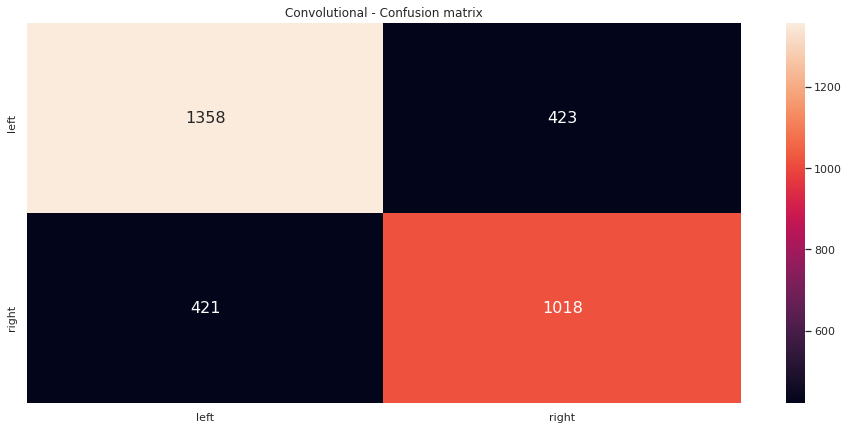

In [16]:
# make prediction
y_pred = model.predict_classes(x_val)
evaluate_model('convolutional', y_val, y_pred, labels_dict)

### Model with embedding layer initialization
We use pretrained word2vec word embeddings to initiallize Embedding layer

### Load word2vec word embeddings

In [ ]:
# https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
embeddings_index = {}
f = open(path.join('articles', 'processed', 'trained_embeddings', 'all100_final.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

### Create embedding matrix

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, embdding_dimension))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

#### Bidirectional LSTM Model

In [ ]:
# set up early stopping callback
callback = EarlyStopping(monitor='loss', patience=2)

with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Embedding(input_dim=vocabulary_size+1,
                        output_dim=embdding_dimension,
                        weights=[embedding_matrix],
                        input_length=max_length,
                        trainable=True))
    model.add(Bidirectional(LSTM(100)))
    model.add(Dense(n_labels_to_predict, activation='sigmoid'))

    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    history = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_val, y_val), verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 8338, 100)         10277000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 402       
Total params: 10,438,202
Trainable params: 10,438,202
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
302/302 [==============================] - 218s 715ms/step - loss: 0.6179 - accuracy: 0.6725 - val_loss: 0.5892 - val_accuracy: 0.6866
Epoch 2/5
302/302 [==============================] - 216s 715ms/step - loss: 0.5573 - accuracy: 0.7154 - val_loss: 0.5715 - val_accuracy: 0.7028
Epoch 3/5
302/302 [==============================] - 215s 713ms/step - loss: 0.509

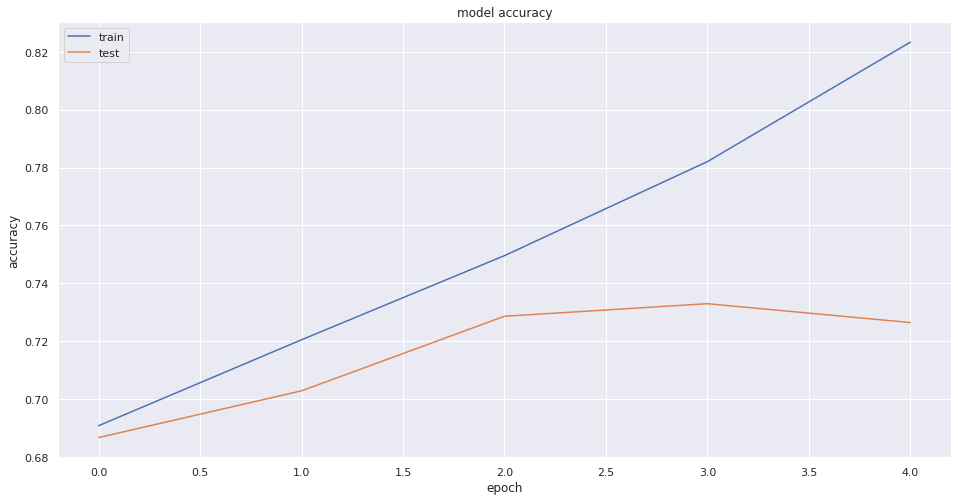

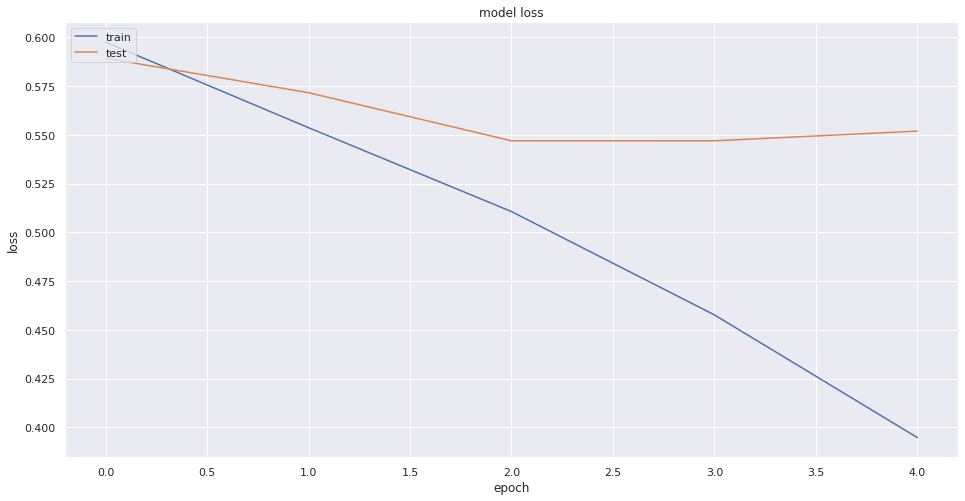

In [ ]:
# plot training lines
plot_training_history(history)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy score: 0.726
Recall score: 0.725
Precision score: 0.725
F1 score: 0.725
Classification report:
              precision    recall  f1-score   support

        left       0.75      0.75      0.75      1733
       right       0.70      0.70      0.70      1487

    accuracy                           0.73      3220
   macro avg       0.72      0.72      0.72      3220
weighted avg       0.73      0.73      0.73      3220



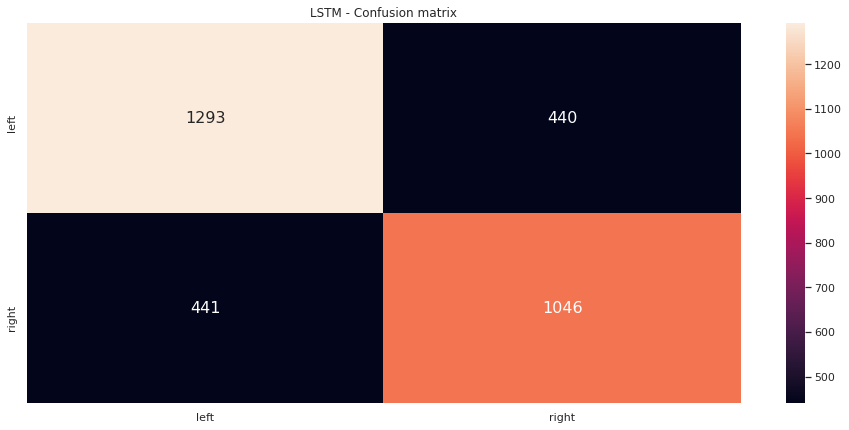

In [ ]:
# make prediction
y_pred = model.predict_classes(x_val)
evaluate_model('lstm', y_val, y_pred, labels_dict)

#### Convolutional NN

In [ ]:
# set up early stopping callback
callback = EarlyStopping(monitor='loss', patience=2)

with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Embedding(input_dim=vocabulary_size + 1,
                        output_dim=embdding_dimension,
                        weights=[embedding_matrix],
                        input_length=max_length,
                        trainable=True))
    
    model.add(Conv1D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(250, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(n_labels_to_predict, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    history = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_val, y_val), verbose=1, callbacks=[callback])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 8338, 100)         10277000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8338, 32)          9632      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4169, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 133408)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               33352250  
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                

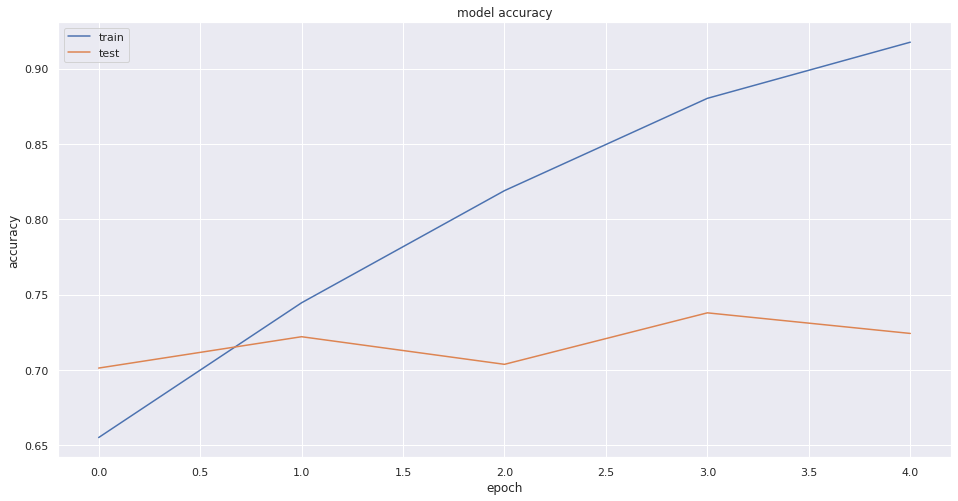

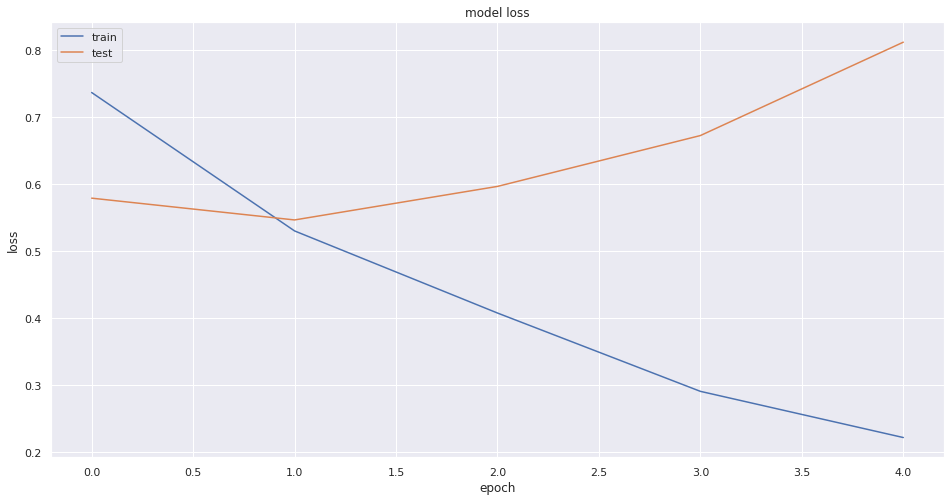

In [ ]:
# plot training lines
plot_training_history(history)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy score: 0.724
Recall score: 0.722
Precision score: 0.723
F1 score: 0.722
Classification report:
              precision    recall  f1-score   support

        left       0.74      0.76      0.75      1733
       right       0.71      0.69      0.70      1487

    accuracy                           0.72      3220
   macro avg       0.72      0.72      0.72      3220
weighted avg       0.72      0.72      0.72      3220



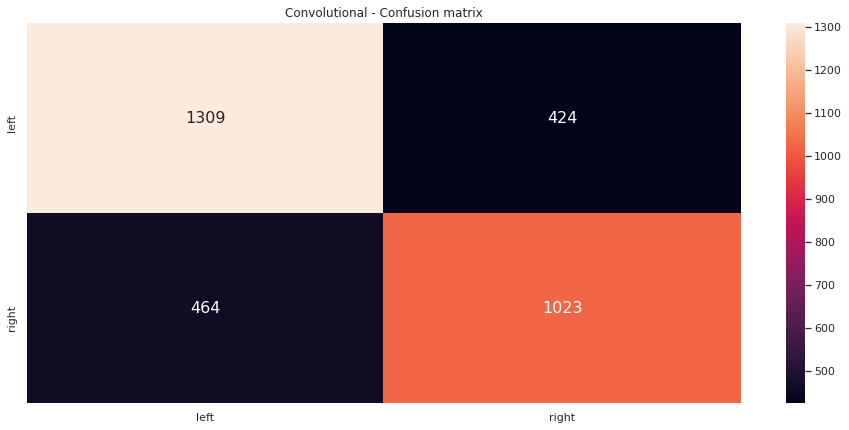

In [ ]:
# make prediction
y_pred = model.predict_classes(x_val)
evaluate_model('convolutional', y_val, y_pred, labels_dict)